This code is meant to be read and executed in tandem with the PDF file `tutorial_connectivity` located in the "course_materials" folder

In [5]:
import numpy as np
import scipy.io as si
import networkx as nx
import matplotlib.pyplot as plt
import bct
import sys

sys.path.append('../src/')
import opencourse.bassett_funcs as bf

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.interpolation'] = 'nearest'

%matplotlib inline

# The dataset
This dataset consists of edge information between nodes of brain activity. These nodes might be individual units, such as neurons, or they might be abstract units such as collections of voxels in fMRI. In addition, we have a snapshot of connectivity across multiple instances of time. In this way, we can investigate clusters of nodes and how they change over time.

First, we'll import data and extract one graph

In [6]:
path_to_data = '../../data/matrices_connectivity.mat'
graphs_raw = si.loadmat(path_to_data)
graphs_raw = graphs_raw['matrices']
graph_raw = graphs_raw[..., 0]

Here's what it looks like...

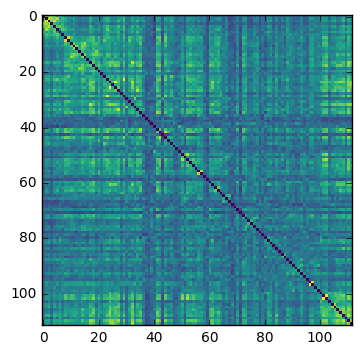

In [7]:
fig, ax = plt.subplots()
ax.imshow(graph_raw, interpolation='nearest');

# Task 1 - Characterize local network structure in neural data

Calculate clustering coefficient for each node

In [8]:
clustering_coef = bct.clustering_coef_wu(graph_raw)

Plot the distribution + mean

mean clustering coefficient: 0.384434


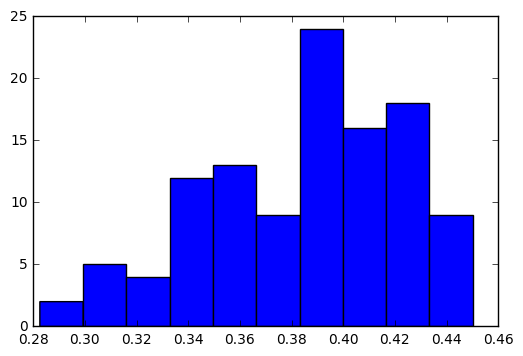

In [9]:
fig, ax = plt.subplots()
ax.hist(clustering_coef)
print('mean clustering coefficient: %f' % clustering_coef.mean())

 Create a random matrix for comparison

In [10]:
tri = np.where(np.triu(graph_raw) == 0)
tri = np.array(tri).T
tri_rnd = np.random.permutation(tri)

# Randomize matrix
graph_raw_r = graph_raw.copy()
for (ii, jj), (ii_rnd, jj_rnd) in zip(tri, tri_rnd):
    graph_raw_r[ii, jj] = graph_raw[ii_rnd, jj_rnd]
    graph_raw_r[jj, ii] = graph_raw[ii_rnd, jj_rnd]

# Clustering coefficient for random matrix
clustering_coef_r = bct.clustering_coef_wu(graph_raw_r)

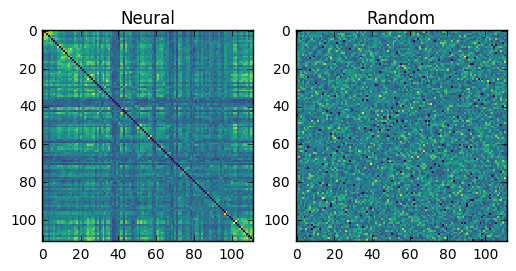

In [11]:
# Compare the structure of neural + random matrix
fig, axs = plt.subplots(1, 2)
axs[0].imshow(graph_raw)
axs[0].set_title('Neural')
axs[1].imshow(graph_raw_r)
axs[1].set_title('Random');

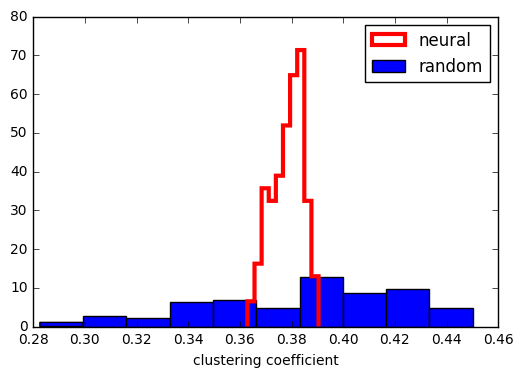

In [12]:
# Compare the clustering coefficients for the two
fig, ax = plt.subplots()
h1 = ax.hist(clustering_coef, normed=True)
h2 = ax.hist(clustering_coef_r, histtype='step', normed=True, color='r', lw=3)
ax.legend(['neural', 'random']);
ax.set_xlabel('clustering coefficient')

As you can see, random data shows clustering coefficients that are much more variable than the data we record in the brain. Let's take this clustering one step further by exploring communities of nodes in the brain.
# Task 2 - Community detection methods to identify modules in neural data

We can use the `louvain` algorithm to find "communities" of nodes.

In [13]:
# It is an iterative algorithm, so the random seed affects initialization
clusters, q_stat = bct.community_louvain(graph_raw,
                                         seed=np.random.randint(10000))

In [14]:
# Repeat this a bunch of times to see how it differs over iterations
all_clusters = np.zeros([100, len(graph_raw)], dtype=int)
for i in range(100):
    clusters, q_stat = bct.community_louvain(graph_raw,
                              seed=np.random.randint(10000))
    all_clusters[i] = clusters

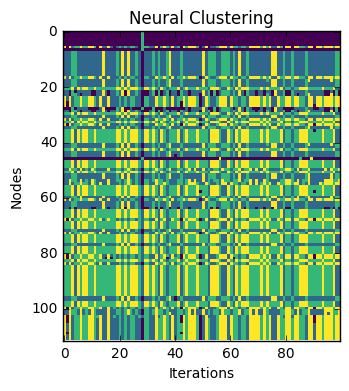

In [19]:
# Visualize cluster identity for each iteration
fig, ax = plt.subplots()
ax.imshow(all_clusters.T, cmap='viridis')
ax.set_title('Neural Clustering')
ax.set_xlabel('Iterations')
ax.set_ylabel('Nodes');

## Compare this for a random graph:

In [20]:
# Repeat this a bunch of times to see how it differs over iterations
all_clusters_r = np.zeros([100, len(graph_raw_r)], dtype=int)
for ii in range(100):
    clusters, q_stat = bct.community_louvain(graph_raw_r,
                              seed=np.random.randint(10000))
    all_clusters_r[ii] = clusters

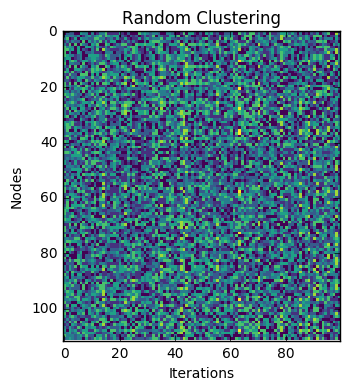

In [21]:
# Visualize cluster identity for each iteration
fig, ax = plt.subplots()
ax.imshow(all_clusters_r.T, cmap='viridis')
ax.set_title('Random Clustering')
ax.set_xlabel('Iterations')
ax.set_ylabel('Nodes')

Now, we'll sort the connectivity matrix so that nodes in the same cluster are near one another. We'll draw out the clusters on the heatmap for one example partiton. We'll do this for the neural data before and after sorting

In [24]:
# Now sort these clustered nodes based on their clustering
ind_sorted, ci_sorted = bf.order_partition(graph_raw, all_clusters[0])
X, Y, _ = bf.find_grid_communities(ci_sorted)

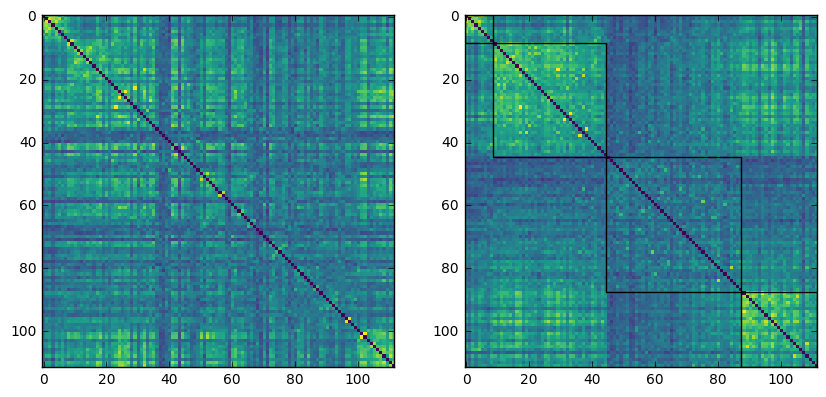

In [25]:
# Plot the original weights, and then sorted by clusters
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(graph_raw)
axs[1].imshow(graph_raw[ind_sorted, :][:, ind_sorted])

# Plot diagonals to show each cluster
axs[1].plot(X, Y, color='k')
plt.autoscale(tight=True)

# Task 3 - Module change over time

Let's investigate each connectivity matrix across time. Do you notice any changes?

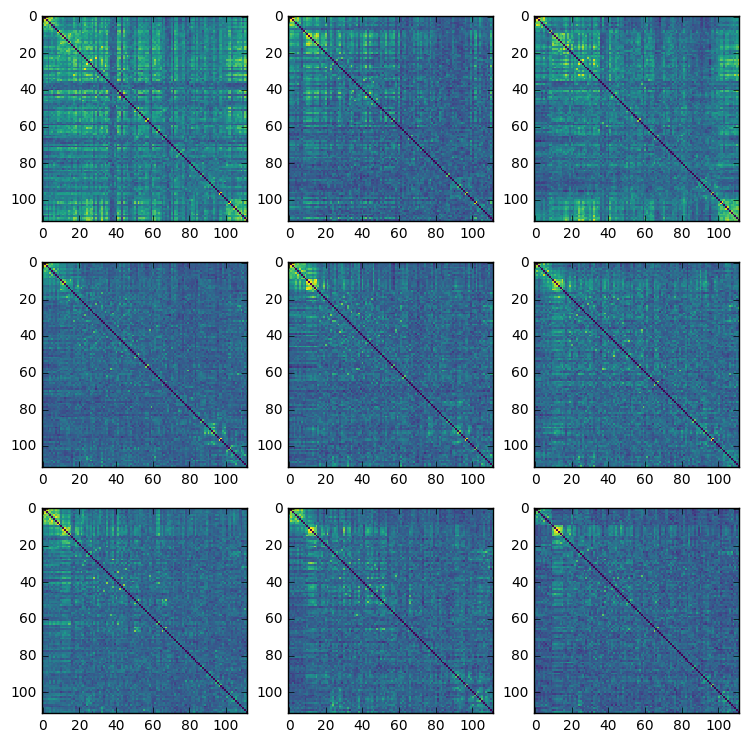

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(graphs_raw[:,:,i*3 + j])
plt.autoscale(tight=True)

We can investigate the extent to which communities persist (or dissolve) over time by calculating the same clustering, but including the time dimension in the analysis. For this, we've expanded the genlouvain algorithm below:

In [27]:
partition_time, q_time = bf.genlouvain_over_time(graphs_raw, omega=1.0)

/Users/choldgraf/anaconda/lib/python2.7/site-packages/bct/algorithms/modularity.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if B in ('negative_sym', 'negative_asym'):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/bct/algorithms/modularity.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if B == 'potts' and np.any(np.logical_not(np.logical_or(W == 0, W == 1))):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/bct/algorithms/modularity.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if B == 'modularity':
/Users/choldgraf/anaconda/lib/python2.7/site-packages/bct/algorithms/modularity.py:145: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

Below we'll show the community assignment for each node as a function of time.

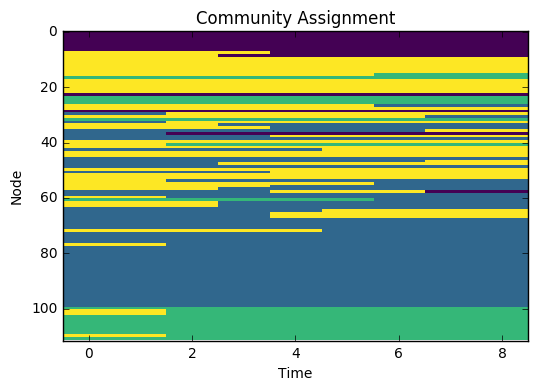

In [29]:
fig, ax = plt.subplots()
ax.imshow(partition_time, aspect='auto')
ax.set_xlabel('Time')
ax.set_ylabel('Node')
ax.set_title('Community Assignment');

Note that while many communities remain stable over time, many others do not.